### Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import sleep
from itertools import cycle
import spotipy 
from spotipy.oauth2 import SpotifyClientCredentials

### Machine Learning Libraries

In [2]:
from sklearn.metrics import accuracy_score,recall_score,precision_score,confusion_matrix,f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

### Functions

In [3]:
def get_audio_features(df, sp):
    
    # check that it is the right CSV
    if 'uri' not in df.columns or 'track' not in df.columns or 'artist' not in df.columns:
        return
    
    # features to keep
    artist_list = []
    track_list = []
    date_list = []
    rating_list = []
    
    # features to obtain from API
    danceability = []
    energy = []
    key = []
    loudness = []
    mode = []
    speechiness = []
    acousticness = []
    instrumentalness = []
    liveness = []
    valence = []
    tempo = []
    duration_ms = []

    # get features for each URI
    for uri, track, artist in df[['uri', 'track', 'artist']].values:
        if uri != 'NaN':
            try:
                x = sp.audio_features(uri)
                
                if x != None:
                    for audio_features in x:
                        danceability.append(audio_features['danceability'])
                        energy.append(audio_features['energy'])
                        key.append(audio_features['key'])
                        loudness.append(audio_features['loudness'])
                        mode.append(audio_features['mode'])
                        speechiness.append(audio_features['speechiness'])
                        acousticness.append(audio_features['acousticness'])
                        instrumentalness.append(audio_features['instrumentalness'])
                        liveness.append(audio_features['liveness'])
                        valence.append(audio_features['valence'])
                        tempo.append(audio_features['tempo'])
                        duration_ms.append(audio_features['duration_ms'])
                        
                    artist_list.append(artist)
                    track_list.append(track)
                    date_list.append(date)
                    rating_list.append(rating)
                
            except:
                continue
    
    # make dataframe
    spotify_data = pd.DataFrame({'artist':artist_list, 'track':track_list, 'danceability':danceability,
                                 'energy':energy, 'key':key, 'loudness':loudness, 'mode':mode,
                                 'speechiness':speechiness, 'acousticness':acousticness, 
                                 'instrumentalness':instrumentalness, 'liveness':liveness,
                                 'valence':valence, 'tempo':tempo, 'duration_ms':duration_ms})
    
    # save CSV file
    #spotify_data.to_csv(target_filename)

    return spotify_data

In [4]:
def get_spotify_uris(df, sp):
    
    # CSV should contain columns:
    # - track
    # - artist
    # - date
    # - rating
    
    # read CSV
    #df = pd.read_csv(csv_file)
    
    # check that it is the right CSV
    if 'track' not in df.columns or 'artist' not in df.columns:
        return
    
    # clean dataframe rows
    #df = df.drop_duplicates()
    #df['track'] = [str(track)[2:-1].split('/')[0].split('(')[0].replace('"','').strip() for track in df['track']]
    #df['artist'] = [str(artist)[2:-1] for artist in df['artist']]
    
    # get URI list
    saved_uris = []
    for artist, track in df[['artist', 'track']].values:
        q = f'artist:{artist} track:{track}'
        results = sp.search(q=q, limit=1, type='track')
        if results['tracks']['total'] != 0:
            uri = results['tracks']['items'][0]['uri']
        else:
            uri = "NaN"
        saved_uris.append(uri)
    
    #print(f'Got {df.shape[0]} URIs.')
    
    # save dataframe
    df['uri'] = saved_uris
    
    # return dataframe
    return df

In [5]:
def authenticate_spotify():
    client_id = '7f6130cdb9904b398f0c0f94b880412f'
    client_secret = '88f25b600aea4def8d7b8f1394c79df8'
    client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
    return spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [6]:
def predict_rating():
    artist = []
    track = []
    artist.append(input("Enter artist name: "))
    track.append(input("Enter track name: "))
    music_df = pd.DataFrame({'artist': artist, 'track': track})
    sp = authenticate_spotify()
    uris_df = get_spotify_uris(music_df, sp)
    if uris_df['uri'][0] != "NaN":
        spotify_data = get_audio_features(uris_df,sp)
        predict = rf.predict(spotify_data.drop(columns = ['artist','track']))
        print("Rating prediction: " + str(predict))
    else:
        print("\nFeatures not found on spotify API")

### Dataset

In [7]:
'''
duration_ms: The duration of the track in milliseconds.

key: The estimated overall key of the track. Integers map to pitches using standard Pitch Class notation.
E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.

mode: Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived.
Major is represented by 1 and minor is 0.

time_signature: An estimated overall time signature of a track. The time signature (meter) is a notational convention to
specify how many beats are in each bar (or measure).

acousticness: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the
track is acoustic.

danceability: Danceability describes how suitable a track is for dancing based on a combination of musical elements
including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most
danceable.

energy: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity.
Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude
scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness,
timbre, onset rate, and general entropy.

instrumentalness: Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this
context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater
likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but
confidence is higher as the value approaches 1.0.

liveness: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability
that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.

loudness: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are
useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological
correlate of physical strength (amplitude). Values typical range between -60 and 0 db.

speechiness: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the
recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks
that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both
music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent
music and other non-speech-like tracks.

valence: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence
sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative
(e.g. sad, depressed, angry).

tempo: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed
or pace of a given piece and derives directly from the average beat duration.'''

'\nduration_ms: The duration of the track in milliseconds.\n\nkey: The estimated overall key of the track. Integers map to pitches using standard Pitch Class notation.\nE.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.\n\nmode: Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived.\nMajor is represented by 1 and minor is 0.\n\ntime_signature: An estimated overall time signature of a track. The time signature (meter) is a notational convention to\nspecify how many beats are in each bar (or measure).\n\nacousticness: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the\ntrack is acoustic.\n\ndanceability: Danceability describes how suitable a track is for dancing based on a combination of musical elements\nincluding tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most\ndanceable.\n\

In [8]:
df = pd.read_csv('rated.csv')

In [9]:
df.head(1)

,artist_id,genres,duration_ms,explicit,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,rating
0,3ojrcDxnCzlXTa04Nj9qRd,"cante flamenco, flamenco, rumba",174150,False,14,0.61,0.232,10,-14.783,1,0.146,0.967,0.000718,0.1,0.76,89.754,4,1.0


In [10]:
df.isna().sum()

artist_id             0
genres              100
duration_ms           0
explicit              0
popularity            0
danceability          0
energy                0
key                   0
loudness              0
mode                  0
speechiness           0
acousticness          0
instrumentalness      0
liveness              0
valence               0
tempo                 0
time_signature        0
rating                0
dtype: int64

In [11]:
df.dtypes

artist_id            object
genres               object
duration_ms           int64
explicit               bool
popularity            int64
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature        int64
rating              float64
dtype: object

### Features

In [12]:
df['rating'] = [round(rating) for rating in df['rating']]

In [13]:
df.shape

(1712, 18)

In [14]:
df.columns

Index(['artist_id', 'genres', 'duration_ms', 'explicit', 'popularity',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'time_signature', 'rating'],
      dtype='object')

### EDA

C:\Users\Bill\AppData\Local\Temp\ipykernel_4312\1057742777.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["danceability"] , color="teal", ax=axes[0, 0])
C:\Users\Bill\AppData\Local\Temp\ipykernel_4312\1057742777.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["energy"] , color="te

C:\Users\Bill\AppData\Local\Temp\ipykernel_4312\1057742777.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["acousticness"] , color="teal", ax=axes[1, 1])
C:\Users\Bill\AppData\Local\Temp\ipykernel_4312\1057742777.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["instrumentalness"] ,

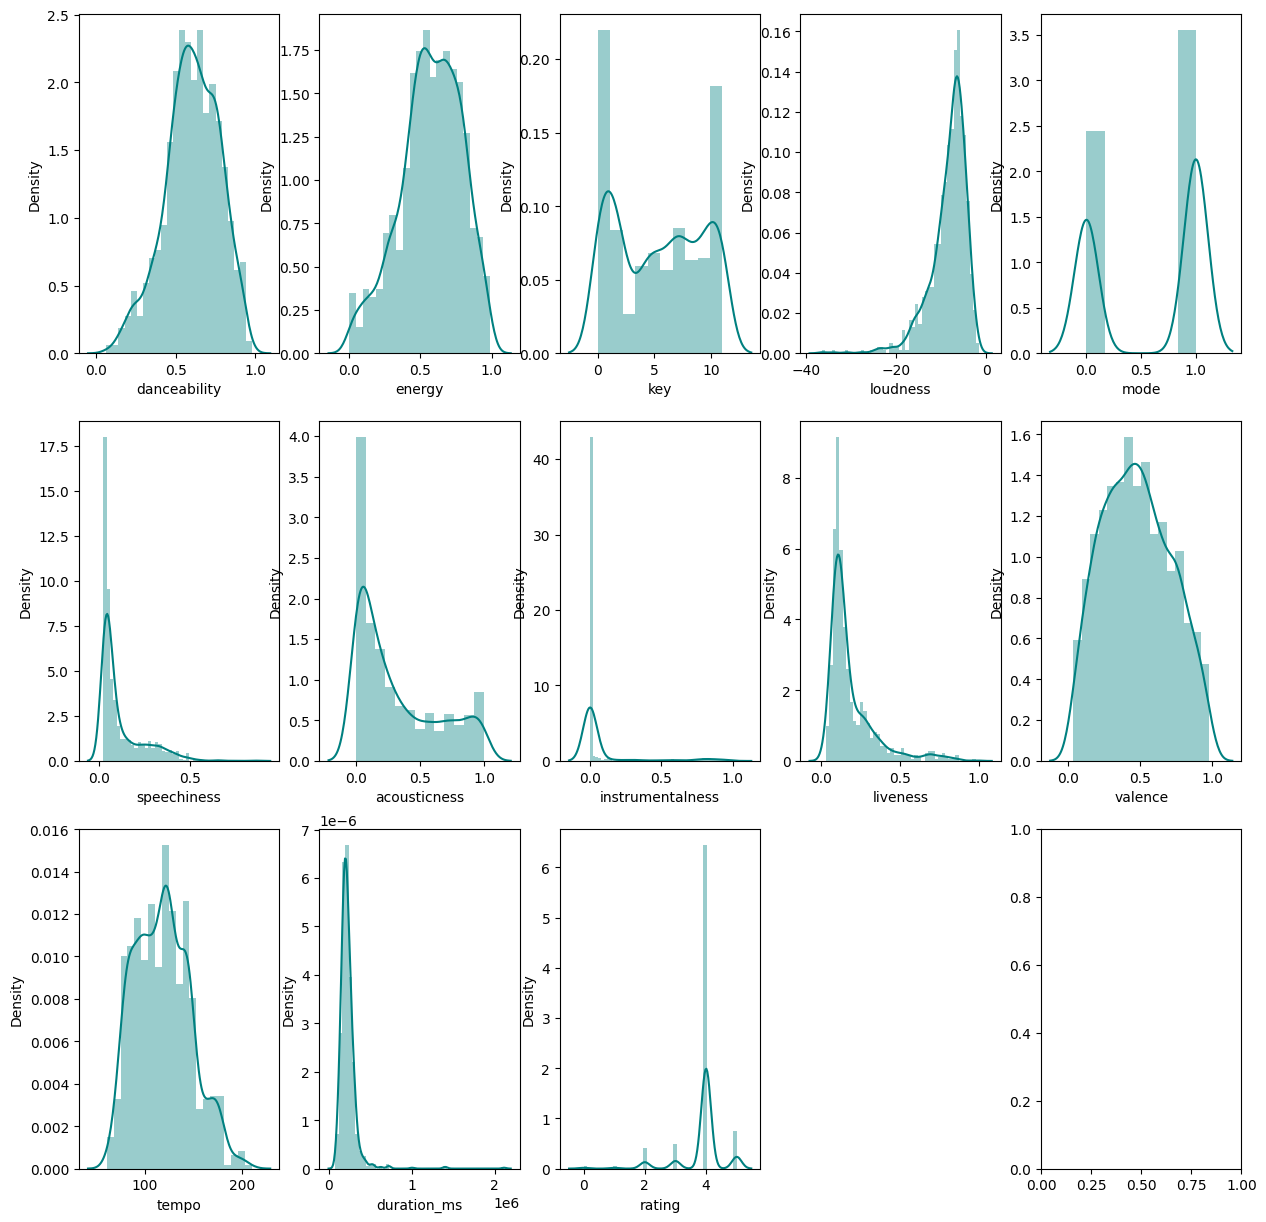

In [15]:
f, axes = plt.subplots(3, 5, figsize=(15, 15))
sns.distplot(df["danceability"] , color="teal", ax=axes[0, 0])
sns.distplot(df["energy"] , color="teal", ax=axes[0, 1])
sns.distplot(df["key"] , color="teal", ax=axes[0, 2])
sns.distplot(df["loudness"] , color="teal", ax=axes[0, 3])
sns.distplot(df["mode"] , color="teal", ax=axes[0, 4])
sns.distplot(df["speechiness"] , color="teal", ax=axes[1, 0])
sns.distplot(df["acousticness"] , color="teal", ax=axes[1, 1])
sns.distplot(df["instrumentalness"] , color="teal", ax=axes[1, 2])
sns.distplot(df["liveness"] , color="teal", ax=axes[1, 3])
sns.distplot(df["valence"] , color="teal", ax=axes[1, 4])
sns.distplot(df["tempo"] , color="teal", ax=axes[2, 0])
sns.distplot(df["duration_ms"] , color="teal", ax=axes[2, 1])
sns.distplot(df["rating"] , color="teal", ax=axes[2, 2])
f.delaxes(axes[2][3])

plt.show()

C:\Users\Bill\AppData\Local\Temp\ipykernel_4312\753639879.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_top_rating["danceability"] , color="orange", ax=axes[0, 0])
C:\Users\Bill\AppData\Local\Temp\ipykernel_4312\753639879.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_top_rating

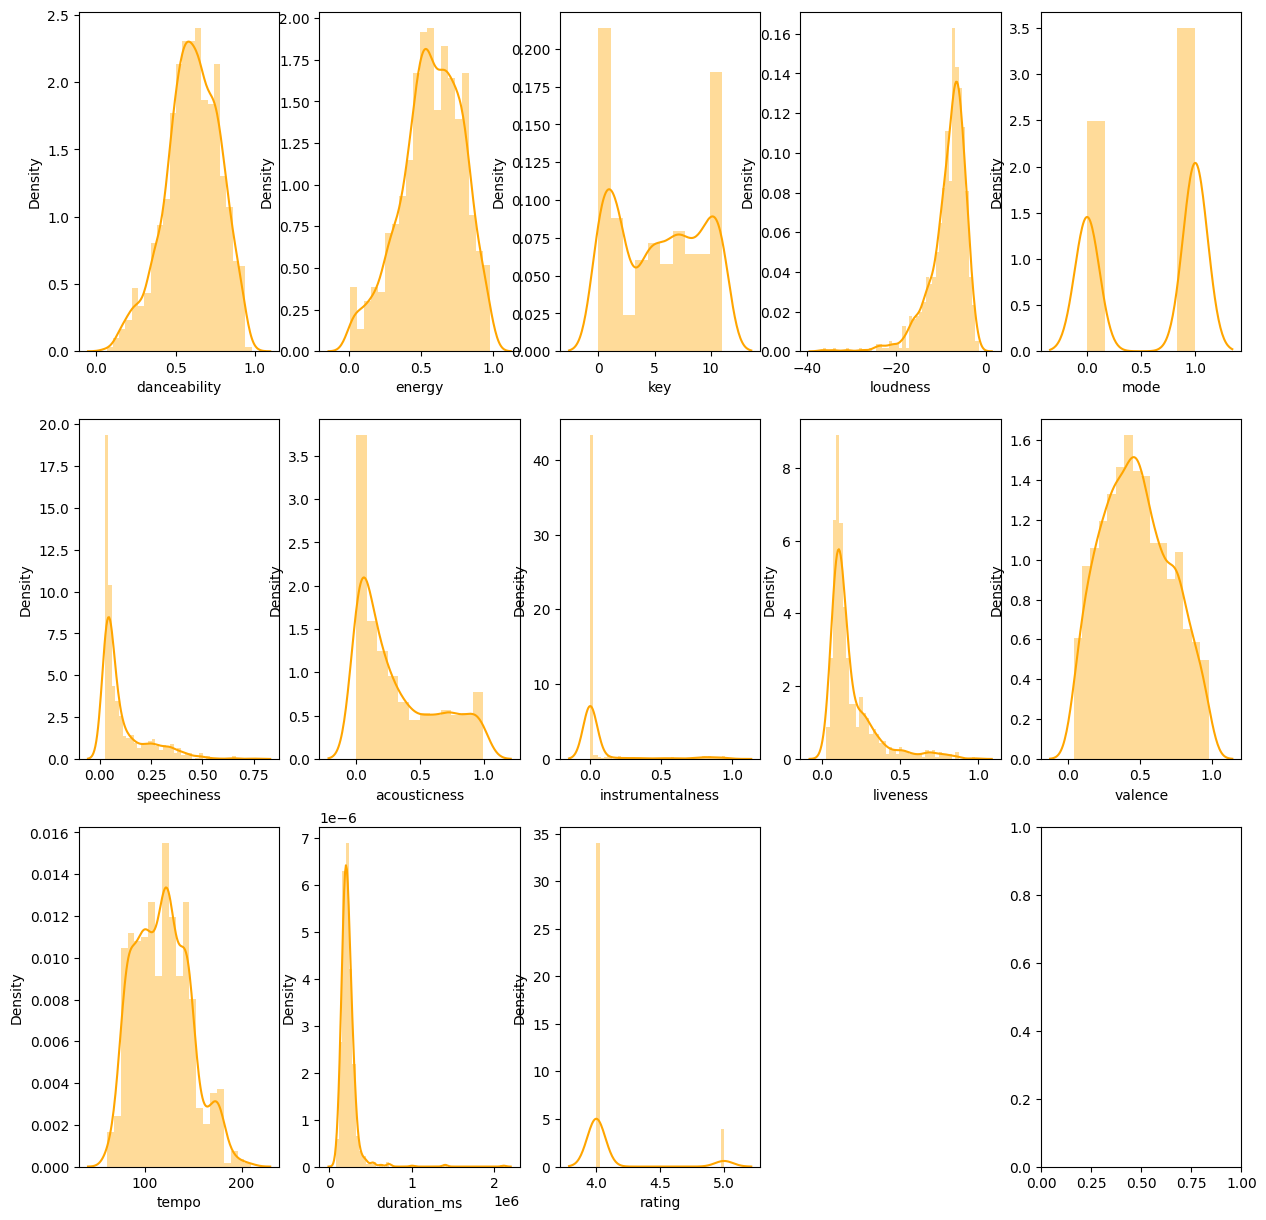

In [16]:
df_top_rating = df.loc[df['rating'] > 3]
f, axes = plt.subplots(3, 5, figsize=(15, 15))
sns.distplot(df_top_rating["danceability"] , color="orange", ax=axes[0, 0])
sns.distplot(df_top_rating["energy"] , color="orange", ax=axes[0, 1])
sns.distplot(df_top_rating["key"] , color="orange", ax=axes[0, 2])
sns.distplot(df_top_rating["loudness"] , color="orange", ax=axes[0, 3])
sns.distplot(df_top_rating["mode"] , color="orange", ax=axes[0, 4])
sns.distplot(df_top_rating["speechiness"] , color="orange", ax=axes[1, 0])
sns.distplot(df_top_rating["acousticness"] , color="orange", ax=axes[1, 1])
sns.distplot(df_top_rating["instrumentalness"] , color="orange", ax=axes[1, 2])
sns.distplot(df_top_rating["liveness"] , color="orange", ax=axes[1, 3])
sns.distplot(df_top_rating["valence"] , color="orange", ax=axes[1, 4])
sns.distplot(df_top_rating["tempo"] , color="orange", ax=axes[2, 0])
sns.distplot(df_top_rating["duration_ms"] , color="orange", ax=axes[2, 1])
sns.distplot(df_top_rating["rating"] , color="orange", ax=axes[2, 2])
f.delaxes(axes[2][3])

plt.show()

ValueError: could not convert string to float: '3ojrcDxnCzlXTa04Nj9qRd'

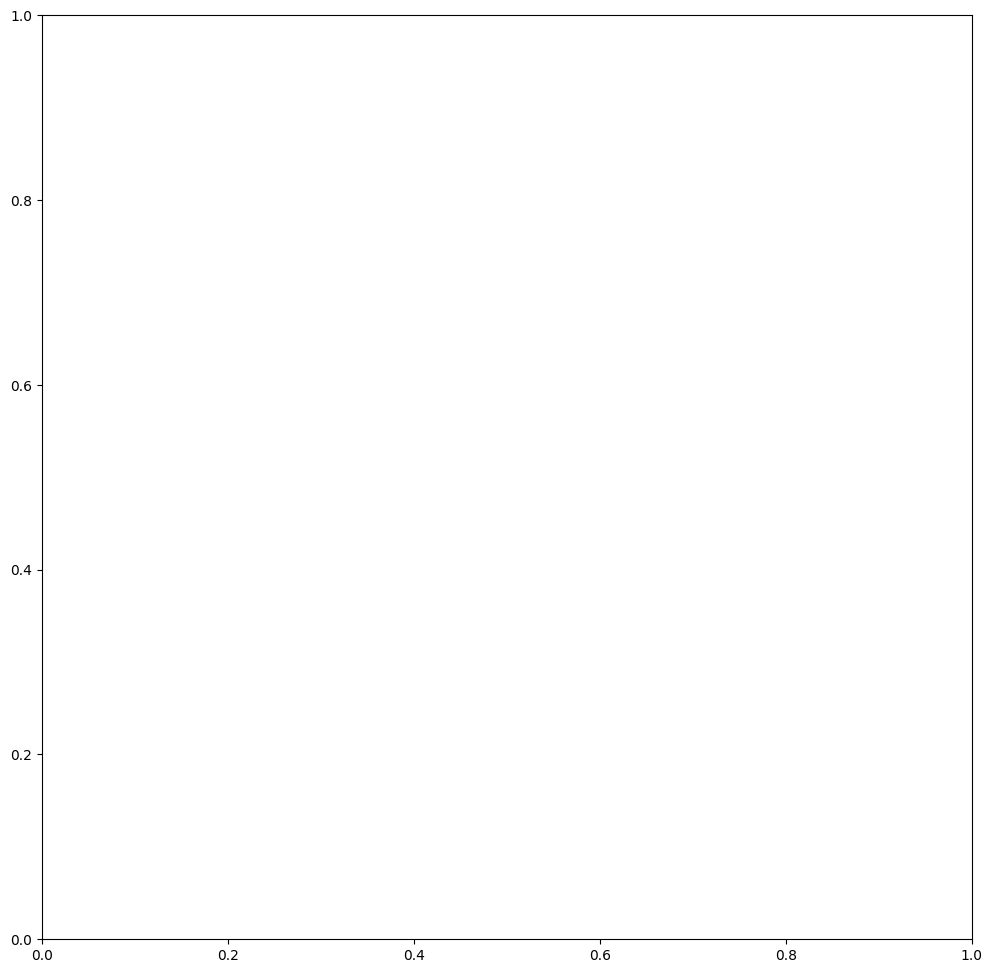

In [17]:
f,ax = plt.subplots(figsize=(12, 12))
mask = np.zeros_like(df.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df.corr(), annot=True, linewidths=0.4,linecolor="white", fmt= '.1f',ax=ax,cmap="Blues",mask=mask)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show() 

### Features

In [18]:
for column in df.columns:
    print(column + " has " + str(len(df[column].value_counts())) + " unique values.")

artist_id has 460 unique values.
genres has 388 unique values.
duration_ms has 811 unique values.
explicit has 2 unique values.
popularity has 88 unique values.
danceability has 482 unique values.
energy has 511 unique values.
key has 12 unique values.
loudness has 812 unique values.
mode has 2 unique values.
speechiness has 543 unique values.
acousticness has 650 unique values.
instrumentalness has 446 unique values.
liveness has 447 unique values.
valence has 551 unique values.
tempo has 836 unique values.
time_signature has 4 unique values.
rating has 6 unique values.


### Logistic Regression

In [19]:
df.columns

Index(['artist_id', 'genres', 'duration_ms', 'explicit', 'popularity',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'time_signature', 'rating'],
      dtype='object')

In [25]:
y = df['rating']
X = df.drop(columns = ['artist_id','rating', 'genres'])

In [26]:
X_train, X_test, y_train, y_test =  train_test_split(X, y, train_size = 0.8, test_size = 0.2)

In [27]:
lr_model = LogisticRegression()

In [28]:
lr_model.fit(X_train, y_train)
y_predict = lr_model.predict(X_test)

In [29]:
logistic_score = accuracy_score(y_test,y_predict)*100

In [30]:
logistic_score

78.71720116618076

### K-Nearest Neighbors

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 29)

In [32]:
k_near_model = KNeighborsClassifier(n_neighbors = 3)
k_near_model.fit(X_train, y_train)
y_predict = k_near_model.predict(X_test)

In [33]:
knn_score = accuracy_score(y_test, y_predict)*100

In [34]:
knn_score

68.22429906542055

### SVM

In [35]:
from sklearn.svm import SVC
svm= SVC(random_state=2)
svm.fit(X_train,y_train)
svm_score = svm.score(X_test,y_test)

In [36]:
svm_score = svm.score(X_test,y_test)*100

In [37]:
svm_score

79.67289719626169

### Naive Bayes

In [38]:
nb= GaussianNB()
nb.fit(X_train,y_train)
nb_score = nb.score(X_test,y_test)*100

In [39]:
nb_score

76.4018691588785

### Decision Tree Classifier

In [40]:
from sklearn.metrics import accuracy_score,recall_score,precision_score,confusion_matrix,f1_score
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
dt= DecisionTreeClassifier()
dt.fit(X_train,y_train)
y_pred=dt.predict(X_test)
DecisionTree_score=dt.score(X_test,y_test)
dt_score = dt.score(X_test,y_test)*100

In [41]:
dt_score

91.58878504672897

### Random Forest Classifier

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 29)

rf=RandomForestClassifier(random_state = 42)
rf.fit(X_train,y_train)
rfc_score = rf.score(X_test,y_test)*100
y_pred=rf.predict(X_test)
t_true=y_test

In [43]:
rfc_score

95.7943925233645

In [44]:
predict_rating()

Max Retries reached


ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- explicit
- popularity
- time_signature


### Cool map

In [45]:
feature_list = X.columns

In [46]:
'''# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')'''

"# Import tools needed for visualization\nfrom sklearn.tree import export_graphviz\nimport pydot\n# Pull out one tree from the forest\ntree = rf.estimators_[5]\n# Import tools needed for visualization\nfrom sklearn.tree import export_graphviz\nimport pydot\n# Pull out one tree from the forest\ntree = rf.estimators_[5]\n# Export the image to a dot file\nexport_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)\n# Use dot file to create a graph\n(graph, ) = pydot.graph_from_dot_file('tree.dot')\n# Write graph to a png file\ngraph.write_png('tree.png')"

### Random Hyperaramter Grid

In [47]:
forestVC = RandomForestClassifier(random_state = 1,
                                  n_estimators = 750,
                                  max_depth = 15, 
                                  min_samples_split = 5,  min_samples_leaf = 1) 
modelVC = forestVC.fit(X_train, y_train) 
y_predVC = modelVC.predict(X_test)

In [48]:
n_estimators = [100, 300, 500, 800, 1200]
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10] 

#hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  min_samples_split = min_samples_split, min_samples_leaf = min_samples_leaf)

#gridF = GridSearchCV(forest, hyperF, cv = 3, verbose = 1, n_jobs = -1)
#bestF = gridF.fit(X_train, y_train)

In [49]:
#bestF.best_params_

In [50]:
# Best Parameters:

'''{'max_depth': 25,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 1200}'''

"{'max_depth': 25,\n 'min_samples_leaf': 2,\n 'min_samples_split': 2,\n 'n_estimators': 1200}"

### New model with hyperparameter

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 29)

rf_improved=RandomForestClassifier(max_depth = 25, min_samples_leaf = 2, min_samples_split = 2, n_estimators = 1200)

rf_improved.fit(X_train,y_train)
rfc_score_improved = rf_improved.score(X_test,y_test)*100
y_pred=rf.predict(X_test)
t_true=y_test
rfc_score_improved

87.61682242990653

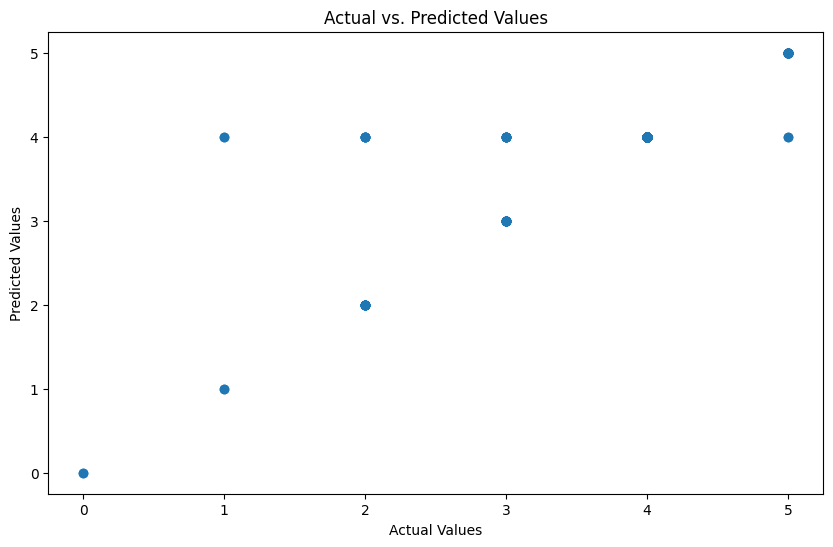

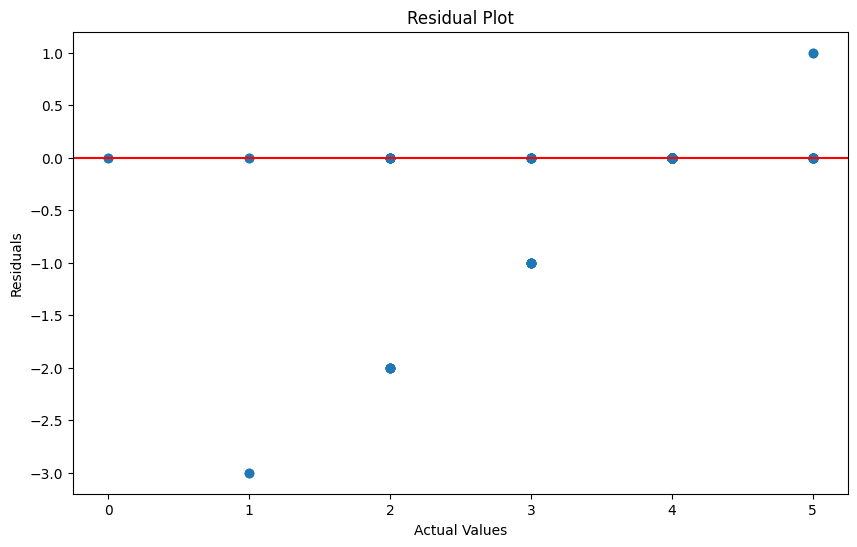

In [56]:
import matplotlib.pyplot as plt

# Scatter plot of actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')

# Add y=x line
# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

plt.show()

# Residual plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals)
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

### Model Comparison

In [52]:
model_performances=pd.DataFrame({'Model':['RandomForestClassifierImproved','RandomForestClassifier','SVM','DesicionTreeClassifier','K-NearestNeighbors','LogisticRegession','NaiveBayes'],
                                 'Accuracy':[rfc_score_improved,rfc_score,svm_score,dt_score,knn_score,logistic_score,nb_score]})
model_performances.sort_values(by = "Accuracy",ascending=False)

,Model,Accuracy
1,RandomForestClassifier,95.794393
3,DesicionTreeClassifier,91.588785
0,RandomForestClassifierImproved,87.616822
2,SVM,79.672897
5,LogisticRegession,78.717201
6,NaiveBayes,76.401869
4,K-NearestNeighbors,68.224299


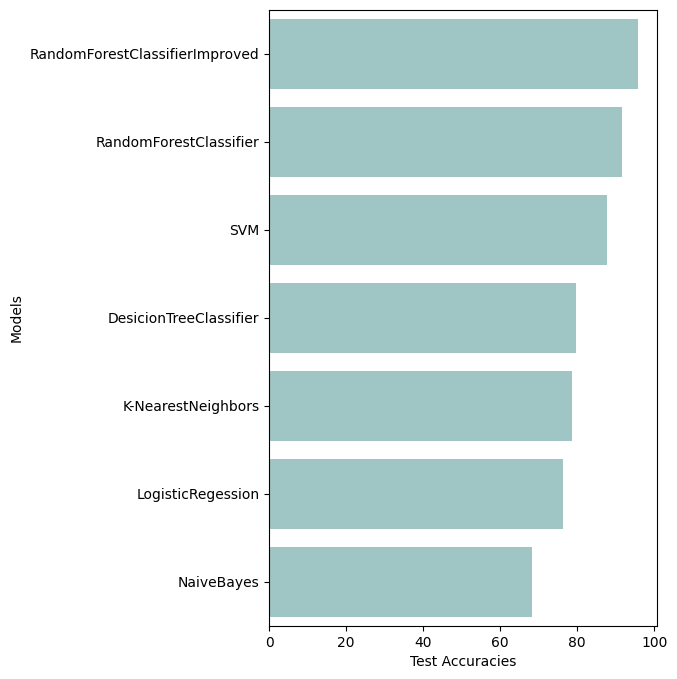

In [53]:
model_list= list(model_performances['Model'].unique())
accuracy_list= list(model_performances['Accuracy'].sort_values(ascending=False))
f,ax = plt.subplots(figsize = (5,8))
sns.barplot(x=accuracy_list,y=model_list,color='teal',alpha = 0.4)
ax.set(xlabel='Test Accuracies', ylabel='Models')
plt.show()

In [54]:
predict_rating()


Features not found on spotify API


In [55]:
predict_rating()


Features not found on spotify API
